<a href="https://colab.research.google.com/github/payo101/ASL-Detection/blob/main/ASL_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"piyusrout","key":"71f444a7f1387e811778bef18826b18c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:11<00:00, 79.8MB/s]
100% 1.03G/1.03G [00:11<00:00, 91.9MB/s]


In [ ]:
!unzip asl-alphabet.zip

In [6]:
!rm asl-alphabet.zip

In [ ]:
!pip install livelossplot

In [20]:
import numpy as np
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

In [9]:
train_list = os.listdir("asl_alphabet_train/asl_alphabet_train")
test_list = os.listdir("asl_alphabet_test/asl_alphabet_test")

In [10]:
if not os.path.isdir("train/"):
  os.mkdir("train")
  for i in train_list:
    shutil.move(os.path.join("asl_alphabet_train/asl_alphabet_train/", i), "train/")

In [11]:
!rm -r asl_alphabet_train
!rm -r asl_alphabet_test

In [12]:
if not os.path.isdir("valid/"):
  os.mkdir("valid")
if not os.path.isdir("test/"):
  os.mkdir("test")

In [13]:
# 72% train, 10% test, 18% valid

if os.path.isdir("valid/") and (not len(os.listdir("valid/"))):
  for dir in os.listdir("train"):
    os.mkdir(os.path.join("valid/", dir))
    valid_class_samples = random.sample(os.listdir(os.path.join("train/", dir)), 540)
    for file_name in valid_class_samples:
      shutil.move(os.path.join("train/", dir, file_name) , os.path.join("valid/", dir))

if os.path.isdir("test/") and (not len(os.listdir("test/"))):
  for dir in os.listdir("train"):
    os.mkdir(os.path.join("test/", dir))
    test_class_samples = random.sample(os.listdir(os.path.join("train/", dir)), 300)
    for file_name in test_class_samples:
      shutil.move(os.path.join("train/", dir, file_name) , os.path.join("test/", dir)) 

In [14]:
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

In [15]:
train_samples = []
valid_samples = []
test_samples = []

for dir in os.listdir(train_dir):
  for files in os.listdir(os.path.join(train_dir, dir)):
    train_samples.append(files)

for dir in os.listdir(valid_dir):
  for files in os.listdir(os.path.join(valid_dir, dir)):
    valid_samples.append(files)

for dir in os.listdir(test_dir):
  for files in os.listdir(os.path.join(test_dir, dir)):
    test_samples.append(files)

In [16]:
print("There are " + str(len(train_samples)) + " training samples.")
print("There are " + str(len(valid_samples)) + " validation samples.")
print("There are " + str(len(test_samples)) + " test samples.")

There are 62640 training samples.
There are 15660 validation samples.
There are 8700 test samples.


##1. Batch Gradient Descent , learning rate = 0.001

In [ ]:
train_datagenerator = ImageDataGenerator(rescale=1/255., 
                                         shear_range=0.2, 
                                         zoom_range=0.2, 
                                         horizontal_flip=True, 
                                         fill_mode='nearest',
                                         rotation_range=7,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2)

valid_datagenerator = ImageDataGenerator(rescale=1/255., 
                                         shear_range=0.2, 
                                         zoom_range=0.2, 
                                         horizontal_flip=True, 
                                         fill_mode='nearest',
                                         rotation_range=7,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2)

In [ ]:
train_data = train_datagenerator.flow_from_directory(train_dir,
                                                     target_size=(200, 200),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     batch_size=64,
                                                     shuffle=True)

valid_data = valid_datagenerator.flow_from_directory(valid_dir,
                                                     target_size=(200, 200),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     batch_size=64,
                                                     shuffle=False)

In [ ]:
model = Sequential()

#Layer 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(200, 200, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

#Layer 2
model.add(Conv2D(128, (3, 3), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

#Layer 3
model.add(Conv2D(256, (3, 3), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

#Layer 4
model.add(Conv2D(512, (3, 3), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())

#FC1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

#FC2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

#Output
model.add(Dense(29, activation='softmax'))

opt = RMSprop(learning_rate=0.001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 50
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = valid_data.n // valid_data.batch_size

checkpoint = ModelCheckpoint('weights.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          min_delta=0.0005,
                          patience=2,
                          verbose=1)

callbacks = [PlotLossesKeras(), checkpoint]

history = model.fit(x=train_data,
                    epochs=epochs,
                    validation_data=valid_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks,
                    verbose=1)

##2. Transfer Learning(Mobile Net)

In [17]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
train_data_mobilenet = datagen.flow_from_directory(train_dir,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     batch_size=64,
                                                     shuffle=True)

valid_data_mobilenet = datagen.flow_from_directory(valid_dir,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     batch_size=64,
                                                     shuffle=True)

test_data_mobilenet = datagen.flow_from_directory(test_dir,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     batch_size=64,
                                                     shuffle=False)

Found 62640 images belonging to 29 classes.
Found 15660 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [19]:
model2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
model2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
inputs = model2.inputs

x = Dense(128, activation='relu')(model2.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(29, activation='softmax')(x)

model_v2 = Model(inputs=inputs, outputs=outputs)

opt = Adam(learning_rate=0.002)

model_v2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_v2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

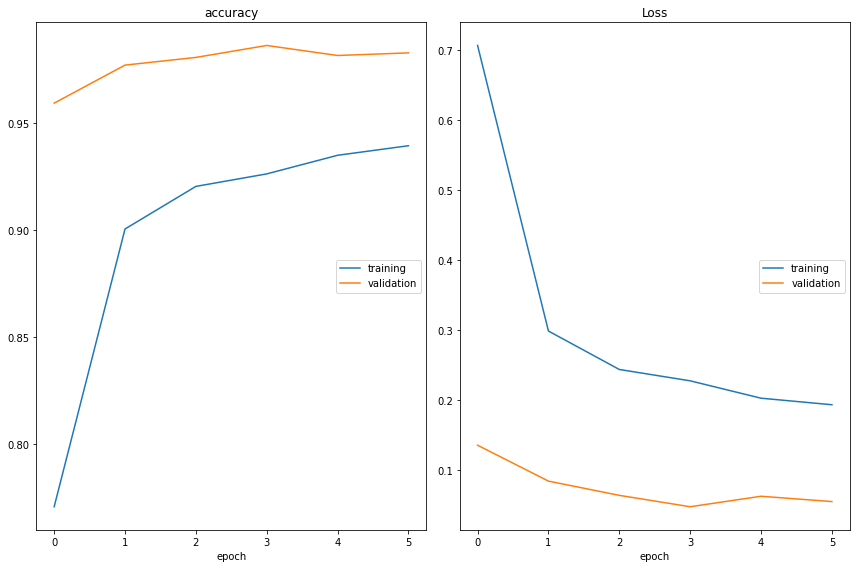

accuracy
	training         	 (min:    0.771, max:    0.939, cur:    0.939)
	validation       	 (min:    0.959, max:    0.986, cur:    0.983)
Loss
	training         	 (min:    0.193, max:    0.707, cur:    0.193)
	validation       	 (min:    0.047, max:    0.135, cur:    0.055)

Epoch 00006: val_accuracy did not improve from 0.98604
Epoch 00006: early stopping


In [26]:
epochs = 50
steps_per_epoch = train_data_mobilenet.n // train_data_mobilenet.batch_size
validation_steps = valid_data_mobilenet.n // valid_data_mobilenet.batch_size

checkpoint = ModelCheckpoint('transfer_learning_weights.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          min_delta=0.0005,
                          patience=2,
                          verbose=1)

callbacks = [PlotLossesKeras(), earlystop, checkpoint]

history = model_v2.fit(x=train_data_mobilenet,
                    epochs=epochs,
                    validation_data=valid_data_mobilenet,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks,
                    verbose=1)

In [30]:
loss, accuracy = model_v2.evaluate(test_data_mobilenet)

136/136 [==============================] - 16s 117ms/step - loss: 0.0553 - accuracy: 0.9815


In [32]:
print("Loss: {:.3f} \n Accuracy: {:.4f}%".format(loss, accuracy*100))

Loss: 0.055 
 Accuracy: 98.1494%


In [33]:
model_v2.save('model_v2.h5')

In [36]:
from google.colab import files
files.download('model_v2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>